In [1]:
%cd ../..

/home/zilian/projects/bachelorproef


/home/zilian/projects/bachelorproef/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
from src.api.db import engine
from sqlalchemy.orm import Session
from src.api.models.db import Recording, SimRoomClass
import matplotlib.pyplot as plt
from src.api.services import embeddings_service 
from concurrent.futures import ThreadPoolExecutor
import shutil
from pathlib import Path
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
from src.config import GAZE_FOVEA_FOV, TOBII_FOV_X
from src.api.services import gaze_service
from src.utils import cv2_video_fps, cv2_video_resolution, cv2_video_frame_count
from torchvision.ops import masks_to_boxes
from tqdm import tqdm
from ultralytics import FastSAM
from torchvision.transforms import InterpolationMode
import traceback
from src.aliases import UInt8Array
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from collections import defaultdict
from src.api.services import simrooms_service


In [ ]:
with Session(engine) as session:
    recording = Recording.get("39f5164f-873d-4d6b-be6b-e1d5db79c02a")
    if recording is None:
        raise ValueError("Recording not found")

    video_path = recording.video_path
    gaze_data_path = recording.gaze_data_path
    
    class_id_to_name = simrooms_service.get_class_id_to_name_map(session, 1)

# Segmenting and Tracking based on Gaze Data, and grounding based on previously built Vector Index

There's a few considerations that might be interesting in an experimental context:
1. Selection of `k` in top-k results from the database?
2. Segmentation quality (IOU?, Confidence?)
3. Adding padding to the bounding boxes?
4. Indexing, search parameters? (which ones exist)
5. Merging of same-frame ROIs or not?
6. Importance of metrics (average, min, max, variance, ?)

In [ ]:
class GazeSegmentationJob:
    def __init__(
        self,
        video_path: Path,
        gaze_data_path: Path,
        results_path: Path,
        fovea_fov: float = GAZE_FOVEA_FOV,
        fov_x: float = TOBII_FOV_X,
        checkpoint_path: str = "checkpoints/FastSAM-x.pt",
        output_video_path: Path | None = None
    ):
        self.video_path = video_path
        self.gaze_data_path = gaze_data_path
        self.fovea_fov = fovea_fov
        self.fov_x = fov_x

        # Set up the results directory.
        self.results_path = results_path
        if self.results_path.exists():
            shutil.rmtree(self.results_path, ignore_errors=True)
            self.results_path.mkdir(parents=True, exist_ok=True)
        self.results_path.mkdir(parents=True, exist_ok=True)

        # Load the FastSAM model.
        self.model = FastSAM(checkpoint_path)

        # Video properties.
        self.resolution = cv2_video_resolution(self.video_path)
        self.aspect_ratio = self.resolution[1] / self.resolution[0] # W / H
        self.fps = cv2_video_fps(self.video_path)
        self.viewed_radius = int((self.fovea_fov / self.fov_x) * self.resolution[1])
        self.frame_count = cv2_video_frame_count(self.video_path)

        # Set up the output video.
        if output_video_path is not None:
            self.video_result = cv2.VideoWriter(
                str(output_video_path),
                cv2.VideoWriter_fourcc(*"mp4v"),
                self.fps,
                (self.resolution[1], self.resolution[0]),
            )
        else:
            self.video_result = None
                

        # Parse gaze data.
        self.gaze_data = gaze_service.parse_gazedata_file(self.gaze_data_path)
        self.gaze_points = gaze_service.get_gaze_points(self.gaze_data, self.resolution)

        # Map frame indexes to gaze points.
        self.frame_gaze_mapping = gaze_service.match_frames_to_gaze(
            self.frame_count, self.gaze_points, self.fps
        )

    def get_gaze_position(self, frame_idx: int) -> tuple[int, int] | None:
        """
        Get the gaze position for a frame index.
        """
        gaze_points = self.frame_gaze_mapping[frame_idx]
        if len(gaze_points) == 0:
            return None
        return gaze_points[0].position

    def mask_too_large(self, mask: torch.Tensor) -> bool:
        """
        Check if the mask area is less than or equal to 30% of the frame area.

        Args:
            mask: A tensor containing a single mask of shape (H, W)
        
        Returns:
            bool: True if the mask's area is less than or equal to 30% of the frame area, False otherwise.
        """
        height, width = mask.shape
        frame_area = height * width
        max_mask_area = 0.1 * frame_area

        mask_area = mask.sum()
        return mask_area >= max_mask_area


    def mask_was_viewed(self, mask: torch.Tensor, gaze_position: tuple[float, float]) -> bool:
        """
        Check if the mask is at least partially within the viewed radius of the gaze point.
        The mask is assumed to be at the original frame size.

        Args:
            mask: A tensor containing a single mask of shape (H, W)
            gaze_position: Tuple (x, y) representing the gaze position.
        
        Returns:
            bool: True if part of the mask falls within the circular area defined by self.viewed_radius, False otherwise.
        """
        height, width = mask.shape
        device = mask.device

        # Create a coordinate grid for the mask.
        y_coords = torch.arange(0, height, device=device).view(-1, 1).repeat(1, width)
        x_coords = torch.arange(0, width, device=device).view(1, -1).repeat(height, 1)
        dist_sq = (x_coords - gaze_position[0]) ** 2 + (y_coords - gaze_position[1]) ** 2

        # Create the circular mask based on self.viewed_radius.
        circular_mask = (dist_sq <= self.viewed_radius ** 2).float()

        # Apply the circular mask to the input mask.
        masked_mask = mask * circular_mask
        return masked_mask.sum() > 0

    def run(self):
        with ThreadPoolExecutor() as executor:
            for frame_idx, results in enumerate(
                self.model.track(source=str(self.video_path), imgsz=640, stream=True)
            ):
                try:
                    gaze_position = self.get_gaze_position(frame_idx)
                    if gaze_position is None:
                        continue

                    boxes = []
                    rois = []
                    object_ids = []
                    for result in results:
                        mask = F.resize(
                            result.masks[0].data,
                            self.resolution,
                            interpolation=InterpolationMode.NEAREST
                        ).squeeze()

                        if not self.mask_too_large(mask) and self.mask_was_viewed(mask, gaze_position):               
                            box = masks_to_boxes(mask.unsqueeze(0)).int().cpu().numpy()[0]
                            x1, y1, x2, y2 = box
                            roi = results[0].orig_img[y1:y2, x1:x2, :]
                            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                            boxes.append(box)
                            rois.append(roi)
                            object_ids.append(int(result.boxes.id[0]))

                    if len(boxes) > 0:
                        # Offload saving with thread pool (asynchronously)
                        rois_array = np.empty(len(rois), dtype=object)
                        for i, roi in enumerate(rois):
                            rois_array[i] = roi

                        executor.submit(
                            np.savez_compressed,
                            self.results_path / f"{frame_idx}.npz",
                            boxes=boxes,
                            rois=rois_array,
                            object_ids=object_ids,
                            frame_idx=frame_idx,
                            gaze_position=gaze_position
                        )

                except Exception as e:
                    print(f"Error processing frame {frame_idx}: {e}")
                    traceback.print_exc()
        


In [5]:
RESULTS_PATH = Path("notebooks/analysis-pipeline/data/fastsam_gaze_segmentation_results")
RESULTS_PATH.mkdir(exist_ok=True)

if len(list(RESULTS_PATH.iterdir())) == 0:
    gaze_sam_job = GazeSegmentationJob(
        video_path=video_path,
        gaze_data_path=gaze_data_path,
        results_path=RESULTS_PATH,
    )
    gaze_sam_job.run()

# RESULT_VIDEO_PATH = Path("notebooks/analysis-pipeline/data/gaze_output.mp4")
# if not RESULT_VIDEO_PATH.exists():#     gaze_sam_job.create_video_from_results(RESULT_VIDEO_PATH)

In [6]:
gaze_segmentation_results = list(RESULTS_PATH.iterdir())
gaze_segmentation_results.sort(key=lambda x: int(x.stem))

gaze_segmentation_results = [np.load(result, allow_pickle=True) for result in gaze_segmentation_results]

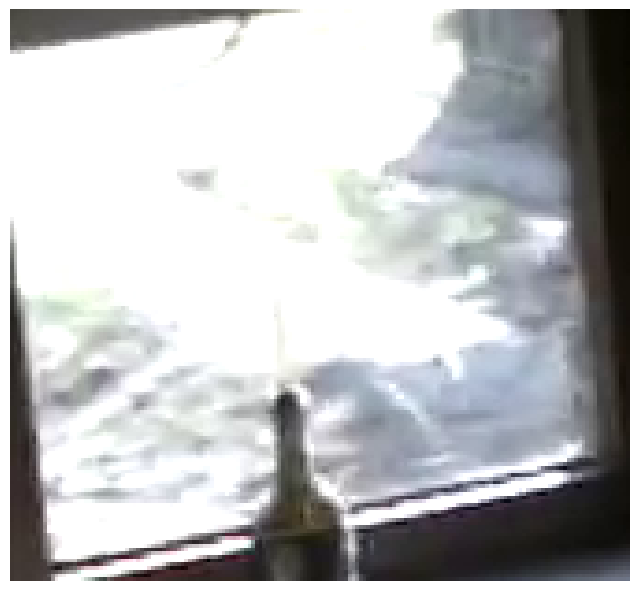

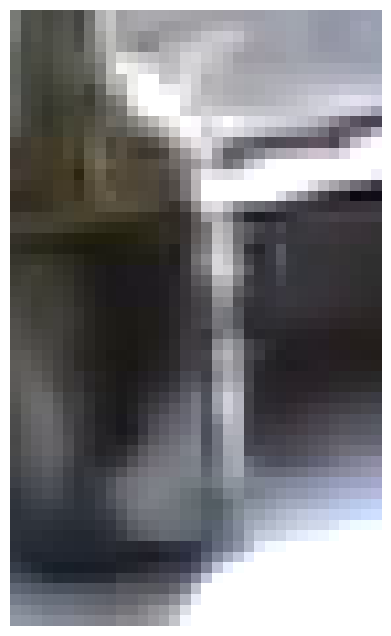

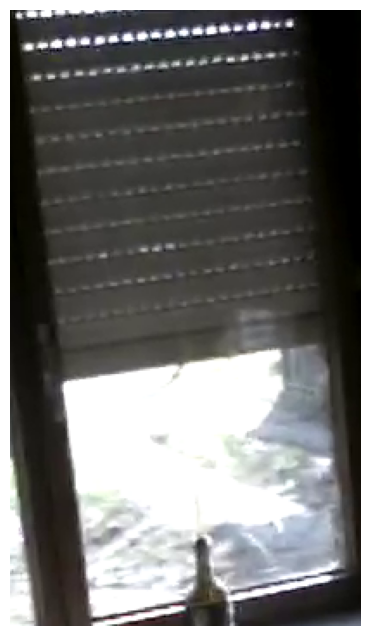

In [7]:
frame_idx = 693
for result in gaze_segmentation_results:
    if result['frame_idx'] != frame_idx:
        continue
    for roi in result['rois']:
        plt.figure(figsize=(8, 8))
        plt.imshow(roi)
        plt.axis("off")
        plt.show()
    break

In [8]:
dinov2 = embeddings_service.load_model()
index = embeddings_service.read_index(Path("notebooks/analysis-pipeline/data/embeddings.index"))

In [12]:
grounding_stats = pd.DataFrame(
    columns=["frame_idx", "object_id", "class_id", "avg_distance", "min_distance", "max_distance", "var_distance"]
)

In [ ]:
rows = []  # to collect each result row

for result in gaze_segmentation_results:
    frame_idx = result['frame_idx']
    rois = result['rois']
    object_ids = result['object_ids']

    # Get embeddings (assuming one batch is returned)
    embeddings, _, _ = list(embeddings_service.get_embeddings(dinov2, rois))[0]
    per_roi_distances, per_roi_class_ids = embeddings_service.search_index(index, embeddings, k=50)

    for i, roi in enumerate(rois):  # iterate over each ROI
        object_id = object_ids[i]
        distances = per_roi_distances[i]
        class_ids = per_roi_class_ids[i]

        # Group distances by class using defaultdict for conciseness
        class_to_dists = defaultdict(list)
        for cid, d in zip(class_ids, distances):
            class_to_dists[cid].append(d)

        # For each class, compute statistics and add a row
        for cid, dists in class_to_dists.items():
            rows.append({
                "frame_idx": frame_idx,
                "object_id": object_id,
                "class_id": cid,
                "avg_distance": np.mean(dists),
                "min_distance": np.min(dists),
                "max_distance": np.max(dists),
                "var_distance": np.var(dists)
            })

grounding_stats = pd.DataFrame(rows)

In [19]:
grounding_stats.head()

,frame_idx,object_id,class_id,avg_distance,min_distance,max_distance,var_distance
0,0,21,9,0.802994,0.694466,0.857712,0.005889
1,0,21,15,0.848607,0.773173,0.891508,0.001212
2,0,21,5,0.862707,0.803628,0.899229,0.000926
3,0,21,10,0.893496,0.888016,0.898976,0.000030
4,0,47,15,0.973738,0.730945,1.073498,0.003436
